
# Export a session as Spike2 data with Photometry data



In [1]:
import os

nb_name = "nb20230315_154600_Spike2Ppotometry.ipynb" #TODO change this

basename, ext = os.path.splitext(nb_name)
input_path = os.path.join(os.getcwd(), nb_name)

!jupyter nbconvert "{input_path}" --to="python" --output="{basename}"

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook d:\OneDrive - Nexus365\Private_Dropbox\Projects\trialexp\notebooks\noncanonical\nb20230315_154600_Spike2Ppotometry.ipynb to python
[NbConvertApp] Writing 17984 bytes to d:\OneDrive - Nexus365\Private_Dropbox\Projects\trialexp\notebooks\noncanonical\nb20230315_154600_Spike2Ppotometry.py


# Imports

In [4]:

# allow for automatic reloading of classes and function when updating the code
%load_ext autoreload
%autoreload 2 

# Import Session and Experiment class with helper functions
from trialexp.process.data_import import *
from trialexp.process.pyphotometry.photometry_functional import *
import pandas as pd
import datetime
import re

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Variables

In [5]:

trial_window = [-2000, 6000]  # in ms

# time limit around trigger to perform an event
# determine successful trials
timelim = [0, 2000]  # in ms

# Digital channel nb of the pyphotometry device
# on which rsync signal is sent (from pycontrol device)
rsync_chan = 2

basefolder, _ = os.path.split(os.path.split(os.getcwd())[0])

# These must be absolute paths
# use this to use within package tasks files (in params)
tasksfile = os.path.join(basefolder, 'params\\tasks_params.csv')
# use this to put a local full path
#tasksfile = -r'C:/.../tasks_params.csv'

# photometry_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\test_folder\photometry'
photometry_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\pyphotometry\data\reaching_go_spout_bar_nov22'
video_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\videos'


In [6]:
tasks = pd.read_csv(tasksfile, usecols=[1, 2, 3, 4], index_col=False)
tasks


,task,triggers,events,conditions
0,lick_go_nogo,go; nogo,bar; bar_off; spout,free_reward
1,lick_go_nogo_unconditionned,go; nogo,bar; bar_off; spout,free_reward
2,lick_go_nogo_unconditionned_opto,go; nogo,bar; bar_off; spout,free_reward
3,reaching_go_nogo,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
4,reaching_go_nogo_jc,CS_plus; CS_minus,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
5,reaching_go_nogo_opto_continuous,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset; s_go_sham; s_go_...
6,reaching_go_nogo_opto_sinusoid,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset_2; s_nogo_cs_onse...
7,reaching_go_nogo_opto_sinusoid_spout,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset_2; s_nogo_cs_onse...
8,reaching_go_nogo_reversal,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
9,reaching_go_nogo_reversal_incentive,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...


### Create an experiment object


In [7]:
# Folder of a full experimental batch, all animals included

# Enter absolute path like this
# pycontrol_files_path = r'T:\Data\head-fixed\test_folder\pycontrol'

# or this if you want to use data from the sample_data folder within the package
#pycontrol_files_path = os.path.join(basefolder, 'sample_data/pycontrol')
pycontrol_files_path = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\pycontrol\reaching_go_spout_bar_nov22'

# Load all raw text sessions in the indicated folder or a sessions.pkl file
# if already existing in folder_path
exp_cohort = Experiment(pycontrol_files_path, update=True)  # TODO

# Only use if the Experiment cohort as been processed by trials before
# TODO: assess whether this can be removed or not
exp_cohort.by_trial = True


smrx_folder_path = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\pycontrol\reaching_go_spout_bar_nov22\processed'


Saved sessions loaded from: sessions.pkl


In [8]:
exp_cohort.match_sessions_to_files(photometry_dir, ext='ppd')
exp_cohort.sync_photometry_files(2)
exp_cohort.save()


d:\onedrive - nexus365\private_dropbox\projects\trialexp\trialexp\utils\rsync.py:78: RuntimeWarning: invalid value encountered in log
  log_mse = np.log(chunk_mse)
d:\onedrive - nexus365\private_dropbox\projects\trialexp\trialexp\utils\rsync.py:78: RuntimeWarning: invalid value encountered in log
  log_mse = np.log(chunk_mse)
d:\onedrive - nexus365\private_dropbox\projects\trialexp\trialexp\utils\rsync.py:78: RuntimeWarning: invalid value encountered in log
  log_mse = np.log(chunk_mse)
d:\onedrive - nexus365\private_dropbox\projects\trialexp\trialexp\utils\rsync.py:78: RuntimeWarning: invalid value encountered in log
  log_mse = np.log(chunk_mse)
d:\onedrive - nexus365\private_dropbox\projects\trialexp\trialexp\utils\rsync.py:78: RuntimeWarning: invalid value encountered in log
  log_mse = np.log(chunk_mse)
d:\onedrive - nexus365\private_dropbox\projects\trialexp\trialexp\utils\rsync.py:78: RuntimeWarning: invalid value encountered in log
  log_mse = np.log(chunk_mse)
d:\onedrive - ne

saved \\ettin\Magill_Lab\Julien\Data\head-fixed\pycontrol\reaching_go_spout_bar_nov22\sessions.pkl


In [9]:

update_all_smrx = False

ss = exp_cohort.sessions

ss_ = [this_ss for this_ss in ss
       if (this_ss.subject_ID in [58])
       and (this_ss.task_name == 'reaching_go_spout_bar_mar23')
       and (this_ss.datetime.date() >= datetime.date(2023, 3, 25))]
ss_


In [10]:
exp_cohort.sessions = ss_


In [11]:
# Many combinations possible
conditions_dict0 = {'trigger': 'hold_for_water', 'valid': True}


# Aggregate all condition dictionaries in a list
condition_list = [conditions_dict0]
# Aliases for conditions
cond_aliases = [
    'any_trial',
]

# Groups as a list of lists
groups = None

# right_handed = [281]
# groups = [[280, 282, 299, 300, 301],\
#     [284, 285, 296, 297, 306, 307]]
# Window to exctract (in ms)


In [12]:
exp_cohort.sessions[0].print_lines[0:30]


['27987 T:21986, this trial > X, type:spout, 0 spouts\n#1: init by spout 0, bar_off 0, btn 0, free 0, miss 1, ---------X',
 '56144 water_on',
 '56144 water by spout',
 '59095 T:53895, this trial > O, type:spout, 6 spouts\n#2: init by spout 1, bar_off 0, btn 0, free 0, miss 1, --------XO',
 '83592 water_on',
 '83592 water by spout',
 '84533 T:80555, this trial > O, type:spout, 2 spouts\n#3: init by spout 2, bar_off 0, btn 0, free 0, miss 1, -------XOO',
 '103266 water_on',
 '103266 water by spout',
 '105553 T:102175, this trial > O, type:spout, 5 spouts\n#4: init by spout 3, bar_off 0, btn 0, free 0, miss 1, ------XOOO',
 '133879 water_on',
 '133879 water by spout',
 '135077 T:132279, this trial > O, type:spout, 5 spouts\n#5: init by spout 4, bar_off 0, btn 0, free 0, miss 1, -----XOOOO',
 '151538 water_on',
 '151538 water by spout',
 '152907 T:150645, this trial > O, type:spout, 6 spouts\n#6: init by spout 5, bar_off 0, btn 0, free 0, miss 1, ----XOOOOO',
 '183347 water_on',
 '183347 w

In [13]:
for ss in exp_cohort.sessions:
    smrxname = re.sub('\.txt', f'_{ss.task_name}.smrx', ss.file_name)
    print(smrxname)


kms058-2023-03-25-184034_reaching_go_spout_bar_mar23.smrx


In [14]:
exp_cohort.sessions[0].print_lines[0]

a = re.sub('\n', '', exp_cohort.sessions[0].print_lines[0])

print(a)


27987 T:21986, this trial > X, type:spout, 0 spouts#1: init by spout 0, bar_off 0, btn 0, free 0, miss 1, ---------X


In [15]:

vars(exp_cohort.sessions[0].photometry_rsync)


{'pulse_times_A': array([      0,    2905,    7486, ..., 5385281, 5391790, 5398235]),
 'pulse_times_B': array([4.725000e+03, 7.631000e+03, 1.221200e+04, ..., 5.390040e+06,
        5.396549e+06, 5.402994e+06]),
 'cor_times_A': array([0.000000e+00, 2.905000e+03, 7.486000e+03, ..., 5.385281e+06,
                 nan,          nan]),
 'cor_times_B': array([4.72500e+03, 7.63100e+03, 1.22120e+04, ..., 5.39004e+06,
                nan,         nan]),
 'units_A': 1,
 'units_B': 1}

in `sync_photometry_file()` in `trialexp\process\pyphotometry\utils.py`

```pythoh
photometry_rsync = Rsync_aligner(pulse_times_A= pycontrol_rsync_times, 
                pulse_times_B= photometry_rsync_times, plot=False)
```

https://pycontrol.readthedocs.io/en/latest/user-guide/synchronisation/#synchronising-data

In [16]:
i = 0

photometry_aligner = Rsync_aligner(exp_cohort.sessions[i].photometry_rsync.pulse_times_A, 
    exp_cohort.sessions[i].photometry_rsync.pulse_times_B,
    chunk_size=5, plot=False, raise_exception=True)
photometry_dict = import_ppd(exp_cohort.sessions[i].files['ppd'][0])
photometry_times_pyc = photometry_aligner.B_to_A(photometry_dict['time'])


In [17]:
lst = list(exp_cohort.sessions[i].__dict__.keys())
print(lst)

['file_name', 'experiment_name', 'task_name', 'setup_ID', 'subject_ID', 'datetime', 'datetime_string', 'events', 'times', 'print_lines', 'v_lines', 'state_IDs', 'event_IDs', 'number', 'files', 'photometry_rsync']


In [18]:
condition_list
cond_aliases

['any_trial']

## modified from `get_photometry_trials`

taken from `trialexp\process\pyphotometry\photometry_functional.py`

confusingly the same name of fuctions are found in 
```
\process\data_import.py
\process\pycontrol\data_import.py
\process\pycontrol\session_analysis.py
\process\pyphotometry\photometry_functional.py
```


parameters are taken from `notebooks\noncanonical\nb20230222_092800_poster_delayed_tasks_photometry.ipynb`
calls `get_photometry_groups` in `trialexp\process\data_import.py`
calls `get_photometry_trials` in `trialexp\process\pyphotometry\photometry_functional.py`

In [19]:
session = exp_cohort.sessions[i]

photometry_dict = import_ppd(session.files['ppd'][0])

trig_on_ev = None
last_before = None
baseline_low_pass = 0.001, # var name changed from former high-pass,
# was misleading on baseline computation
# see https://github.com/juliencarponcy/trialexp/issues/8
# first fix 
low_pass = 45
median_filt = 3
motion_corr = True
df_over_f = True
z_score = True
downsampling_factor = 10
return_full_session = True
export_vars = ['analog_1_df_over_f', 'zscored_df_over_f']

if low_pass:
    # Filter signals with specified high and low pass frequencies (Hz).
    b, a = get_filt_coefs(low_pass=low_pass, high_pass=None, sampling_rate=photometry_dict['sampling_rate'])
    
    if median_filt:
        analog_1_medfilt = median_filtering(photometry_dict['analog_1'], medfilt_size = median_filt)
        analog_2_medfilt = median_filtering(photometry_dict['analog_2'], medfilt_size = median_filt)
        photometry_dict['analog_1_filt'] = filtfilt(b, a, analog_1_medfilt)
        photometry_dict['analog_2_filt'] = filtfilt(b, a, analog_2_medfilt)

    else:
        photometry_dict['analog_1_filt'] = filtfilt(b, a, photometry_dict['analog_1'])
        photometry_dict['analog_2_filt'] = filtfilt(b, a, photometry_dict['analog_2'])
else:
    if median_filt:
        photometry_dict['analog_1_filt'] = median_filtering(photometry_dict['analog_1'], medfilt_size = median_filt)
        photometry_dict['analog_2_filt'] = median_filtering(photometry_dict['analog_2'], medfilt_size = median_filt)  
    else:
        photometry_dict['analog_1_filt'] = photometry_dict['analog_2_filt'] = None
# TODO: verify/improve/complement the implementation of the following:


if motion_corr == True:

    slope, intercept, r_value, p_value, std_err = linregress(x=photometry_dict['analog_2_filt'], y=photometry_dict['analog_1_filt'])
    photometry_dict['analog_1_est_motion'] = intercept + slope * photometry_dict['analog_2_filt']
    photometry_dict['analog_1_corrected'] = photometry_dict['analog_1_filt'] - photometry_dict['analog_1_est_motion']
    
    if df_over_f == False:
        export_vars.append('analog_1_corrected')
        # signal = photometry_dict['analog_1_corrected']
    elif df_over_f == True:
        # fror 
        b,a = butter(2, baseline_low_pass, btype='low', fs=photometry_dict['sampling_rate'])
        photometry_dict['analog_1_baseline_fluo'] = filtfilt(b,a, photometry_dict['analog_1_filt'], padtype='even')

        # Now calculate the dF/F by dividing the motion corrected signal by the time varying baseline fluorescence.
        photometry_dict['analog_1_df_over_f'] = photometry_dict['analog_1_corrected'] / photometry_dict['analog_1_baseline_fluo'] 
        export_vars.append('analog_1_df_over_f')
        # signal = photometry_dict['analog_1_df_over_f']
if z_score:
    # z-score the signal
    photometry_dict['zscored_df_over_f'] = zscore(photometry_dict['analog_1_df_over_f'])
    export_vars.append('zscored_df_over_f')
elif baseline_low_pass or low_pass:
    # signal = photometry_dict['analog_1_filt']']
    export_vars.append('analog_1_filt')

    # control = photometry_dict['analog_2_filt']']
else:
    export_vars.append('analog_1')
# signal = photometry_dict['analog_1']']

# only keep unique items (keys for the photometry_dict)
export_vars = list(set(export_vars))

if downsampling_factor:
    # downsample
    for k in export_vars:
        photometry_dict[k] = decimate(photometry_dict[k], downsampling_factor) 
    # adjust sampling rate accordingly (maybe unnecessary)
    photometry_dict['sampling_rate'] = photometry_dict['sampling_rate'] / downsampling_factor

# fs = photometry_dict['sampling_rate']

df_meta_photo = pd.DataFrame(columns=['subject_ID', 'datetime', 'task_name', 'condition_ID', 'trial_nb'])

# Prepare dictionary output with keys are variable names and values are columns index
col_names_numpy = {var: var_idx for var_idx, var in enumerate(export_vars)}






In [20]:
trials_idx = np.zeros((1, 1))
timestamps_pycontrol = np.zeros((1, 1))

print(trials_idx.shape)

(1, 1)


In [21]:

# assumes that sync between pycontrol and photometry has been performed in previous step
timestamps_photometry = session.photometry_rsync.A_to_B(timestamps_pycontrol)

photometry_idx = (timestamps_photometry / (1000/photometry_dict['sampling_rate'])).round().astype(int)

# retain only trials with enough values left and right
complete_mask = (photometry_idx + trial_window[0]/(1000/photometry_dict['sampling_rate']) >= 0) & (
    photometry_idx + trial_window[1] < len(photometry_dict[export_vars[0]])) 

# complete_idx = np.where(complete_mask)
# trials_idx = np.array(trials_idx)
# photometry_idx = np.array(photometry_idx)

trials_idx = trials_idx[complete_mask]           
photometry_idx = photometry_idx[complete_mask]

# if verbose:
#     print(f'condition {condition_ID} trials: {len(trials_idx)}')

if len(trials_idx) == 0:
    print('nothing')

# Construct ranges of idx to get chunks (trials) of photometry data with np.take method 
photometry_idx = [range(idx + int(trial_window[0]/(1000/photometry_dict['sampling_rate'])) ,
    idx + int(trial_window[1]/(1000/photometry_dict['sampling_rate']))) for idx in photometry_idx]

In [22]:
photo_array = np.ndarray((len(trials_idx), len(photometry_idx[0]),len(export_vars)))

for var_idx, photo_var in enumerate(export_vars):
    # print(f'condition {condition_ID} var: {var_idx} shape {np.take(photometry_dict[photo_var], photometry_idx).shape}')
    photo_array[:,:,var_idx] = np.take(photometry_dict[photo_var], photometry_idx)


df_meta_photo['trial_nb'] = trials_idx
df_meta_photo['subject_ID'] = session.subject_ID
df_meta_photo['datetime'] = session.datetime
df_meta_photo['task_name'] = session.task_name
# df_meta_photo['condition_ID'] = condition_ID


In [23]:

if 'photo_array' in locals():
            photo_array = photo_array.swapaxes(2,1)
else:
    # This occurs when no photometry data is recored at all for the session
    # would occur anyway without the previous check, 
    # avoid it happening spontaneously on return.
    # useless but could be use to convey extra information to calling method
    
    if verbose:
        print(f'No photometry data to collect for subject ID:{session.subject_ID}\
            \nsession: {session.datetime}')

    raise UnboundLocalError()

    # Trying to implement empty arrays and dataframe when nothing to return
    # df_meta_photo = pd.DataFrame(columns=['subject_ID', 'datetime', 'task_name', 'condition_ID', 'trial_nb'])
    # ra
    # photo_array = np.ndarray((len(trials_idx), len(photometry_idx),len(export_vars)))

# df_meta_photo, col_names_numpy, photo_array, photometry_dict


# session.plot_session()

In [ ]:


session.plot_session(keys=[], export_smrx = True, smrx_filename = 'temp.smrx', photometry_dict = photometry_dict)


In [ ]:
keys = [
    'button_press', 'bar', 'bar_off', 'spout', 'US_delay_timer', 'CS_offset_timer']

state_def = [
    {'name': 'waiting_for_bar',    'onset': 'waiting_for_bar',
        'offset': 'hold_for_water'},
    {'name': 'hold_for_water',    'onset': 'hold_for_water',
        'offset': ['waiting_for_spout', 'break_after_abort']},
    {'name': 'waiting_for_spout',    'onset': 'waiting_for_spout',
        'offset': ['busy_win', 'break_after_trial']},
    {'name': 'busy_win',    'onset': 'busy_win',    'offset': 'break_after_trial'},
    {'name': 'break_after_trial', 'onset': 'break_after_trial',
        'offset': 'waiting_for_bar'},
    {'name': 'break_after_abort', 'onset': 'break_after_abort', 'offset': 'waiting_for_bar'}]


bw = ss.times['busy_win']
sp = ss.times['spout']

x_spout = [this_bw for this_bw in bw for spouts in sp if (
    spouts < this_bw) and (this_bw - spouts < 100)]

x_bar = [this_bw for this_bw in bw if not any(
    [(spouts < this_bw) and (this_bw - spouts < 100) for spouts in sp])]
    
event_ms = [{
    'name': 'triggered by spout',
    'time_ms': x_spout
},
{
    'name': 'triggered by bar_off',
    'time_ms': x_bar
}
]

session.plot_session(keys, state_def, export_smrx=True, smrx_filename = 'temp1.smrx', event_ms=event_ms, photometry_dict = photometry_dict)


# Photometry data processing?



In [28]:
[print(k) for k in photometry_dict.keys()];

analog_1
analog_2
digital_1
digital_2
pulse_inds_1
pulse_inds_2
pulse_times_1
pulse_times_2
time
subject_ID
date_time
mode
sampling_rate
volts_per_division
LED_current
version
analog_1_filt
analog_2_filt
analog_1_est_motion
analog_1_corrected
analog_1_baseline_fluo
analog_1_df_over_f
zscored_df_over_f


In [36]:
nan_indices = np.argwhere(np.isnan(photometry_times_pyc))
T_nonan = np.delete(photometry_times_pyc, nan_indices)
max_time_ms = T_nonan[-1]

def get_newTandY_orig(T, photometry_dict, name, max_time_ms):
    T = photometry_times_pyc # not down-sampled yet

    nan_indices = np.argwhere(np.isnan(T))
    T_nonan = np.delete(T, nan_indices)

    Y = photometry_dict[name]
    Y_nonan = np.delete(Y, nan_indices)  # []
    max_time_ms = T_nonan[-1]



    new_T = np.arange(0, max_time_ms, 1/1000*1000) #NOTE sampling_rate was originally 1000
    new_Y = np.interp(new_T, T_nonan, Y_nonan)
    return new_T, new_Y


def get_newTandY_down(T, photometry_dict, name, max_time_ms):
    Tdown = [T[i] for i in range(0, len(T), 10)] #down sampled time vector

    nan_indices = np.argwhere(np.isnan(Tdown))
    Tdown_nonan = np.delete(Tdown, nan_indices)

    Y = photometry_dict[name]
    Y_nonan = np.delete(Y, nan_indices) # []

    # Need to use interp to accomodate data into Spike2 bins
    new_T = np.arange(0, max_time_ms, 1/photometry_dict['sampling_rate']*1000) #NOTE sampling_rate is already downsampled by 10
    new_Y = np.interp(new_T, Tdown_nonan, Y_nonan)
    return new_T, new_Y


process/pyphotometry/utils.py/motion_corretion()

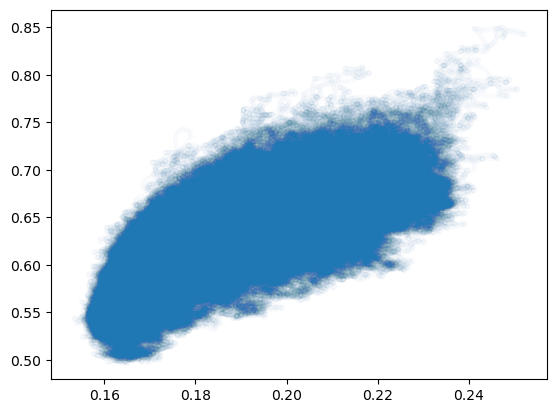

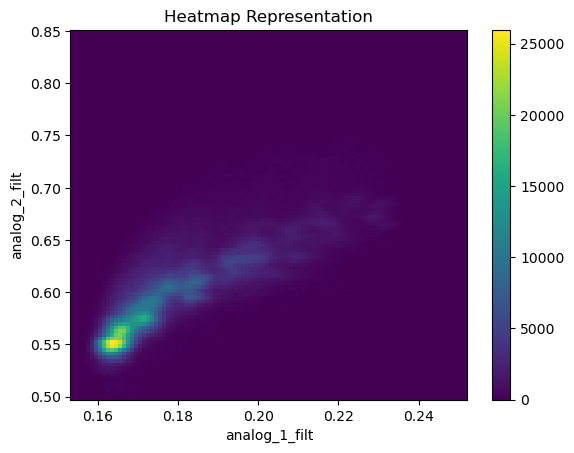

In [56]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

T = photometry_times_pyc
time_vec_ms = np.arange(0, max_time_ms, 1000/1e-3)
t, y1 = get_newTandY_orig(T, photometry_dict, 'analog_1_filt', max_time_ms)

t, y2 = get_newTandY_orig(T, photometry_dict, 'analog_2_filt', max_time_ms)
plt.plot(y1, y2,marker='.', linestyle=None, mfc='none', alpha=0.01)

plt.show()

fig, ax = plt.subplots()

plt.hist2d(y1, y2, bins=(100, 100), cmap='viridis')

# Add a colorbar
plt.colorbar()

# Customize and show the plot
plt.xlabel('analog_1_filt')
plt.ylabel('analog_2_filt')
plt.title('Heatmap Representation')
# plt.grid(True)
plt.show()

slope: 0.325
intercept: -0.015
r_value: 0.816
p_value: 0.0


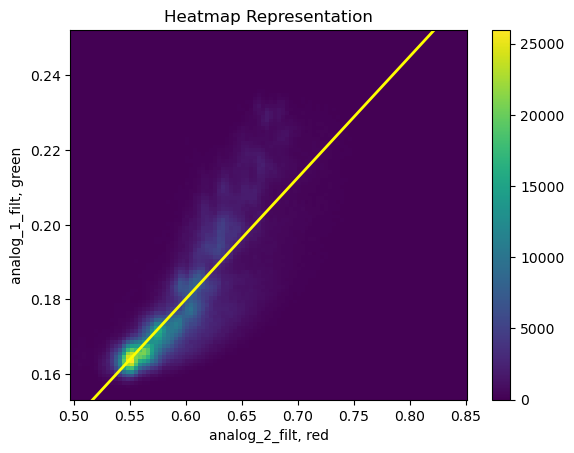

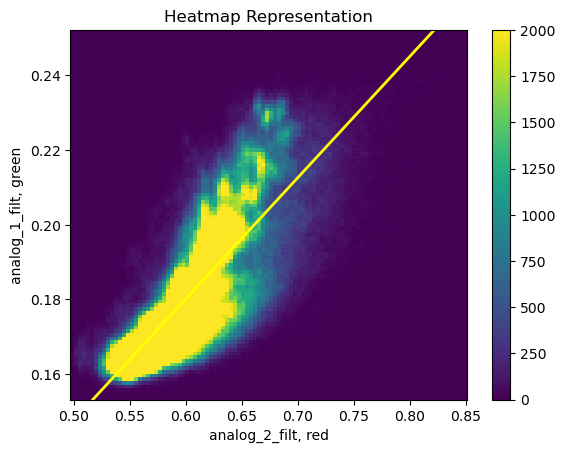

In [86]:
slope, intercept, r_value, p_value, std_err = linregress(
    x=photometry_dict['analog_2_filt'], y=photometry_dict['analog_1_filt'])

print(f"slope: {slope:.3f}\nintercept: {intercept:.3f}\nr_value: {r_value:.3f}\np_value: {p_value}")




fig, ax = plt.subplots()

plt.hist2d(y2, y1, bins=(100, 100), cmap='viridis')

# Add a colorbar
plt.colorbar()

x0 = np.arange(np.min(y2), np.max(y2), (np.max(y2) - np.min(y2))/1000)
y0 = slope*x0 + intercept

plt.plot(x0, y0, '-', color='yellow', linewidth=2)

# Customize and show the plot
plt.xlabel('analog_2_filt, red')
plt.ylabel('analog_1_filt, green')
plt.title('Heatmap Representation')
# plt.grid(True)
plt.show()

fig, ax = plt.subplots()

plt.hist2d(y2, y1, bins=(100, 100), cmap='viridis', vmax=2000)
plt.plot(x0, y0, '-', color='yellow', linewidth=2)
plt.colorbar()

plt.xlabel('analog_2_filt, red')
plt.ylabel('analog_1_filt, green')
plt.title('Heatmap Representation')
plt.show()


This method uses motion artifacts and real signals together.  

My concern is that because there are so many data points at baseline, eg X = 0.55, y= 0.165, the regression cofficients are not working well to fit values with higher fluorescence.

I suspect that the intercept is working well but the slope is far from being accurate.

Perhaps we need to apply some kind of adjusted weight to carry out regression better.

It appears that at higher X and Y values, data points go further up from the regression line. Because they have more than baseline signals, this deflection may be critical. 

In other words, the regressdion line is __underestimating__ an effect from motion captured in red channels.

Then, model predicted motion component is expected to be lower than the signals in analog_1. In reality, it is too big. So the direction of error is not 

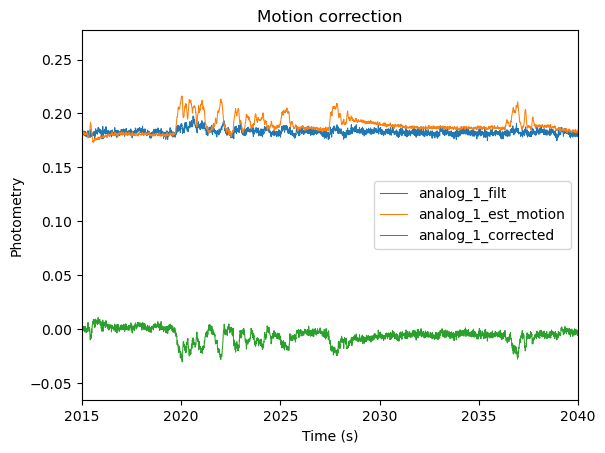

In [78]:
fig, ax = plt.subplots()

t, y3 = get_newTandY_orig(T, photometry_dict, 'analog_1_est_motion', max_time_ms)
t, y4 = get_newTandY_orig(T, photometry_dict, 'analog_1_corrected', max_time_ms)

plt.plot(t/1000, y1, '-', label='analog_1_filt', linewidth=0.75)
# plt.plot(t/1000, y2, '-', label='analog_2_filt', linewidth=0.75)
plt.plot(t/1000, y3, '-', label='analog_1_est_motion', linewidth=0.75)
plt.plot(t/1000, y4, '-', label='analog_1_corrected', linewidth=0.75)

# Customize and show the plot
plt.legend()

plt.xlabel('Time (s)')
plt.ylabel('Photometry')
plt.title('Motion correction')
# plt.grid(True)
plt.xlim(2015,2040)
plt.show()